## MSN 514 HW : 2
### Erinç Ada Ceylan 22101844

#### 1) Define the func and its analytic derrivatives

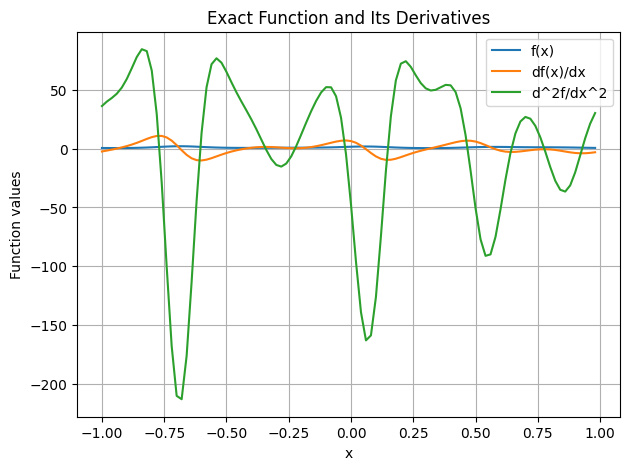

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

N_points = 100
L_box = 1.0
x_vals = np.linspace(-L_box, L_box, N_points, endpoint=False)
dx_val = x_vals[1] - x_vals[0]

def exact_function(x):
    return np.exp(0.5 * np.cos(3 * np.pi * x) + 0.25 * np.sin(5 * np.pi * x))

def exact_derivatives(x):
    f_val = exact_function(x)
    g_prime = -0.5 * 3 * np.pi * np.sin(3 * np.pi * x) + 0.25 * 5 * np.pi * np.cos(5 * np.pi * x)
    g_double_prime = -0.5 * (3 * np.pi)**2 * np.cos(3 * np.pi * x) - 0.25 * (5 * np.pi)**2 * np.sin(5 * np.pi * x)
    df_val = f_val * g_prime
    ddf_val = f_val * (g_prime**2 + g_double_prime)
    return f_val, df_val, ddf_val

f_exact, df_exact, ddf_exact = exact_derivatives(x_vals)

plt.figure(figsize=(7,5))
plt.plot(x_vals, f_exact, label='f(x)')
plt.plot(x_vals, df_exact, label='df(x)/dx')
plt.plot(x_vals, ddf_exact, label='d^2f/dx^2')
plt.title("Exact Function and Its Derivatives")
plt.xlabel("x")
plt.ylabel("Function values")
plt.legend()
plt.grid(True)
plt.show()


#### 2) Finite Difference, stencil [3, 5, 7, 9]

In [2]:
def finite_diff_derivative(data_array, dx, derivative_order, stencil):
    A_list = []
    for nth_power in range(len(stencil)):
        A_list.append(stencil**nth_power)
    A_mat = np.array(A_list, dtype=float)
    
    b_vec = np.zeros((len(stencil), 1))
    b_vec[derivative_order] = math.factorial(derivative_order)
    
    coeffs = np.linalg.inv(A_mat) @ b_vec
    
    shifted_arrays = []
    for s in stencil:
        shifted_arrays.append(np.roll(data_array, -s))
    derivative_array = sum(coeffs[i] * shifted_arrays[i] for i in range(len(stencil))) / (dx**derivative_order)
    
    return derivative_array.ravel()


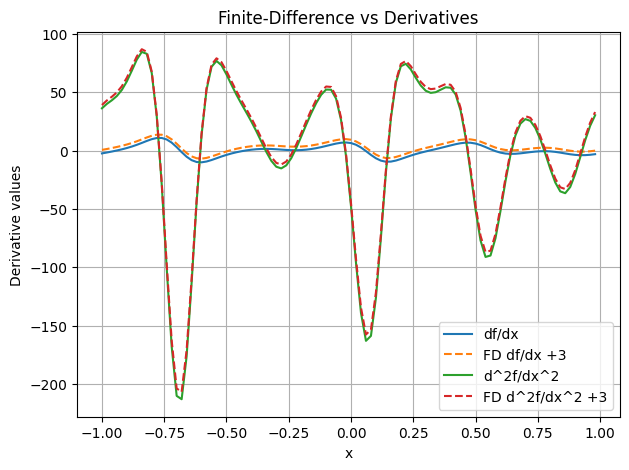

In [3]:
#comparision

stencil_3pt = np.array([-1, 0, 1])

df_approx_3pt = finite_diff_derivative(f_exact, dx_val, 1, stencil_3pt)
ddf_approx_3pt = finite_diff_derivative(f_exact, dx_val, 2, stencil_3pt)

plt.figure(figsize=(7,5))
plt.plot(x_vals, df_exact, label='df/dx')
plt.plot(x_vals, df_approx_3pt +3, '--', label='FD df/dx +3')
plt.plot(x_vals, ddf_exact, label='d^2f/dx^2')
plt.plot(x_vals, ddf_approx_3pt +3, '--', label='FD d^2f/dx^2 +3')
plt.title("Finite-Difference vs Derivatives")
plt.xlabel("x")
plt.ylabel("Derivative values")
plt.legend()
plt.grid(True)
plt.show()


#### 2) Error Analysis for different N values

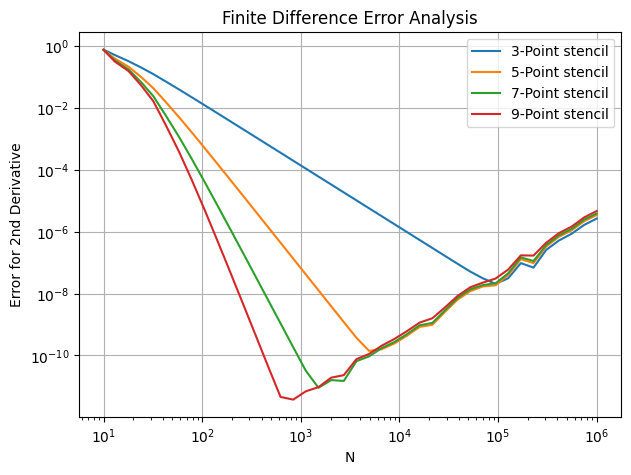

In [4]:
#used l2 norm for ALL error calculations in the hw

def compute_fd_error(num_points, derivative_order, stencil):
    L_temp = 1.0
    x_temp = np.linspace(-L_temp, L_temp, num_points, endpoint=False)
    dx_temp = x_temp[1] - x_temp[0]
    
    f_t, df_t, ddf_t = exact_derivatives(x_temp)
    
    if derivative_order == 1:
        exact_array = df_t
    else:
        exact_array = ddf_t
    
    numeric_deriv = finite_diff_derivative(f_t, dx_temp, derivative_order, stencil)
    
    return np.sqrt(np.sum((exact_array - numeric_deriv)**2)) / np.sqrt(np.sum(exact_array**2))

stencils = {
    "3-Point": np.arange(-1, 2),
    "5-Point": np.arange(-2, 3),
    "7-Point": np.arange(-3, 4),
    "9-Point": np.arange(-4, 5),
}

N_values = np.logspace(1, 6, 40, dtype=int)
errors_dict = {key: [] for key in stencils}

for Nn in N_values:
    for key, st in stencils.items():
        err_val = compute_fd_error(Nn, 2, st)
        errors_dict[key].append(err_val)

plt.figure(figsize=(7,5))
for label_key in stencils:
    plt.loglog(N_values, errors_dict[label_key], label=f"{label_key} stencil")
plt.xlabel("N")
plt.ylabel("Error for 2nd Derivative")
plt.title("Finite Difference Error Analysis")
plt.legend()
plt.grid(True)
plt.show()


#### 4) FFT

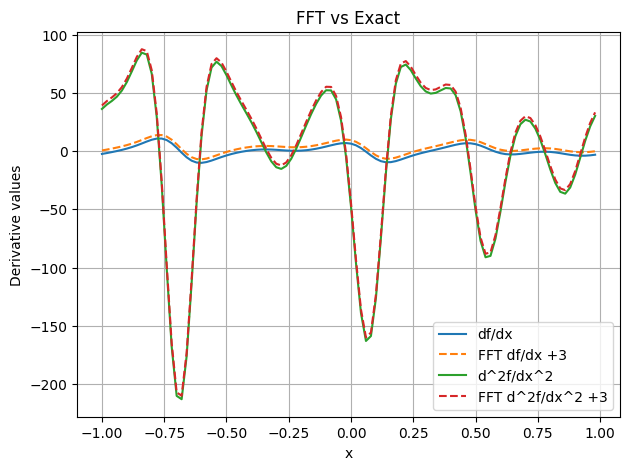

In [5]:
def fft_based_derivative(f_arr, dx, order=1):
    N = len(f_arr)
    k_array = 2.0 * np.pi * np.fft.fftfreq(N, d=dx)
    f_hat = np.fft.fft(f_arr)
    
    if order == 1:
        deriv_hat = 1j * k_array * f_hat
    elif order == 2:
        deriv_hat = -(k_array**2) * f_hat
    else:
        raise ValueError("Only order=1 or 2 in this example.")
    
    return np.fft.ifft(deriv_hat).real

df_fft_approx = fft_based_derivative(f_exact, dx_val, order=1)
ddf_fft_approx = fft_based_derivative(f_exact, dx_val, order=2)

plt.figure(figsize=(7,5))
plt.plot(x_vals, df_exact, label='df/dx')
plt.plot(x_vals, df_fft_approx +3, '--', label='FFT df/dx +3')
plt.plot(x_vals, ddf_exact, label='d^2f/dx^2')
plt.plot(x_vals, ddf_fft_approx +3, '--', label='FFT d^2f/dx^2 +3')
plt.title("FFT vs Exact")
plt.xlabel("x")
plt.ylabel("Derivative values")
plt.legend()
plt.grid(True)
plt.show()


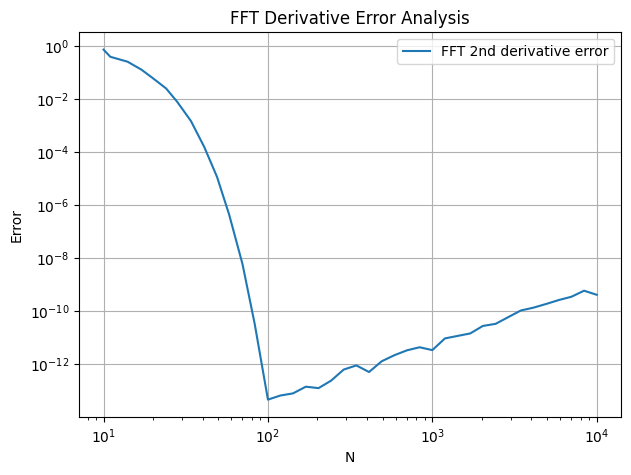

In [6]:
#error for FFT
def fft_error_analysis(Nn, order):
    x_loc = np.linspace(-L_box, L_box, Nn, endpoint=False)
    dx_loc = x_loc[1] - x_loc[0]
    f_l, df_l, ddf_l = exact_derivatives(x_loc)
    
    if order == 1:
        numeric = fft_based_derivative(f_l, dx_loc, order=1)
        exact   = df_l
    else:
        numeric = fft_based_derivative(f_l, dx_loc, order=2)
        exact   = ddf_l
    
    return np.sqrt(np.sum((exact - numeric)**2)) / np.sqrt(np.sum(exact**2))

N_range = np.logspace(1, 4, 40, dtype=int)
fft_errs = []
for n_size in N_range:
    fft_errs.append(fft_error_analysis(n_size, order=2))

plt.figure(figsize=(7,5))
plt.loglog(N_range, fft_errs, label='FFT 2nd derivative error')
plt.xlabel("N")
plt.ylabel("Error")
plt.title("FFT Derivative Error Analysis")
plt.grid(True)
plt.legend()
plt.show()


#### 5) DFT

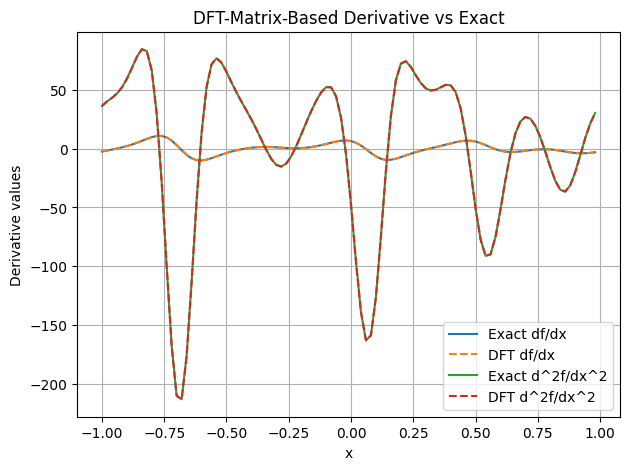

In [7]:
def dft_matrix_derivative(f_arr, dx, order=1):
    N = len(f_arr)
    k_vals = (np.arange(N) - N//2) * (2*np.pi / (N * dx))
    x_indices = (np.arange(N) - N//2) * dx
    F_matrix = np.zeros((N, N), dtype=complex)
    for row in range(N):
        for col in range(N):
            F_matrix[row,col] = np.exp(-1j * k_vals[row] * x_indices[col])
    f_hat_dft = (F_matrix @ f_arr) / N
    if order == 1:
        df_hat = 1j * k_vals * f_hat_dft
    elif order == 2:
        df_hat = -(k_vals**2) * f_hat_dft
    else:
        raise ValueError("Only implemented for order=1 or 2.")
    F_conjugate = np.conj(F_matrix)
    derivative_dft = F_conjugate.T @ df_hat
    return np.real(derivative_dft)

df_dft_approx = dft_matrix_derivative(f_exact, dx_val, order=1)
ddf_dft_approx = dft_matrix_derivative(f_exact, dx_val, order=2)

plt.figure(figsize=(7,5))
plt.plot(x_vals, df_exact, label='Exact df/dx')
plt.plot(x_vals, df_dft_approx, '--', label='DFT df/dx')
plt.plot(x_vals, ddf_exact, label='Exact d^2f/dx^2')
plt.plot(x_vals, ddf_dft_approx, '--', label='DFT d^2f/dx^2')
plt.title("DFT-Matrix-Based Derivative vs Exact")
plt.xlabel("x")
plt.ylabel("Derivative values")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
#tabulating the dft matrix
from tabulate import tabulate

N = len(f_exact)
k_vals = (np.arange(N) - N//2) * (2*np.pi / (N * dx_val))
x_indices = (np.arange(N) - N//2) * dx_val
F_matrix = np.zeros((N, N), dtype=complex)
for row in range(N):
    for col in range(N):
        F_matrix[row, col] = np.exp(-1j * k_vals[row] * x_indices[col])

print("F_matrix:")
print(tabulate(F_matrix, tablefmt="fancy_grid"))


F_matrix:
╒════╤═════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤═══════════╤══════════════╤════════════╤═════════════╤════════════╤══════════════╤════════════╤═════════════╤════════════╤══════════════╤═══════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤═════════════╤════════════╤══════════════╤═══════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤═════════════╤═══════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤═══╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤═══════════╤═════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤════════════╤══════════════╤═══════════╤══════════════╤══════════

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tabulate/__init__.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  conv(string)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tabulate/__init__.py:1232: ComplexWarning: Casting complex values to real discards the imaginary part
  return format(float(val), floatfmt)


#### 6) Accuracy vs. N 

Processed N=10 in 0.00 seconds
Processed N=21 in 0.00 seconds
Processed N=46 in 0.00 seconds
Processed N=100 in 0.01 seconds
Processed N=215 in 0.02 seconds
Processed N=464 in 0.11 seconds
Processed N=1000 in 0.49 seconds
Processed N=2154 in 2.33 seconds
Processed N=4641 in 10.66 seconds
Processed N=10000 in 50.75 seconds


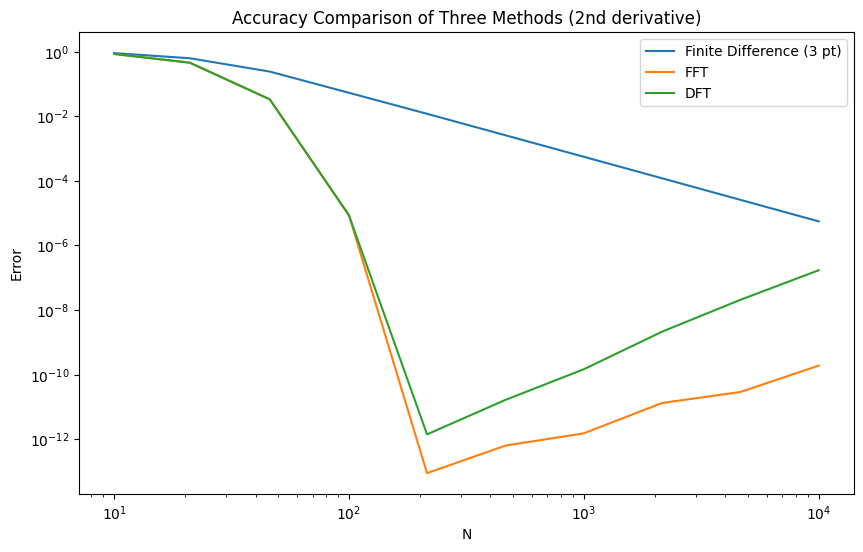

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt

def fd_error(N, derivative_order, stencil):
    L_local = 2.0
    x_grid = np.linspace(-L_local, L_local, N, endpoint=False)
    dx_local = x_grid[1] - x_grid[0]
    f_ex, df_ex, ddf_ex = exact_derivatives(x_grid)
    
    exact_arr = df_ex if derivative_order == 1 else ddf_ex
    approx_arr = finite_diff_derivative(f_ex, dx_local, derivative_order, stencil)
    error_val = np.sqrt(np.sum((exact_arr - approx_arr)**2)) / np.sqrt(np.sum(exact_arr**2))
    return error_val

def fft_error(N, derivative_order):
    L_local = 2.0
    x_grid = np.linspace(-L_local, L_local, N, endpoint=False)
    dx_local = x_grid[1] - x_grid[0]
    f_ex, df_ex, ddf_ex = exact_derivatives(x_grid)
    
    exact_arr = df_ex if derivative_order == 1 else ddf_ex
    approx_arr = fft_based_derivative(f_ex, dx_local, derivative_order)
    error_val = np.sqrt(np.sum((exact_arr - approx_arr)**2)) / np.sqrt(np.sum(exact_arr**2))
    return error_val

def dft_error(N, derivative_order):
    L_local = 2.0
    x_grid = np.linspace(-L_local, L_local, N, endpoint=False)
    dx_local = x_grid[1] - x_grid[0]
    f_ex, df_ex, ddf_ex = exact_derivatives(x_grid)
    
    exact_arr = df_ex if derivative_order == 1 else ddf_ex
    approx_arr = dft_matrix_derivative(f_ex, dx_local, derivative_order)
    error_val = np.sqrt(np.sum((exact_arr - approx_arr)**2)) / np.sqrt(np.sum(exact_arr**2))
    return error_val

deriv_order = 2
stencil_3pt = np.array([-1, 0, 1])
N_values = np.logspace(1, 4, 10, dtype=int)
fd_err_array = []
fft_err_array = []
dft_err_array = []

for Nn in N_values:
    start_time = time.time()
    
    fd_err_array.append(fd_error(Nn, deriv_order, stencil_3pt))
    fft_err_array.append(fft_error(Nn, deriv_order))
    dft_err_array.append(dft_error(Nn, deriv_order))
    
    end_time = time.time()
    print(f"Processed N={Nn} in {end_time - start_time:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.loglog(N_values, fd_err_array, label='Finite Difference (3 pt)')
plt.loglog(N_values, fft_err_array, label='FFT')
plt.loglog(N_values, dft_err_array, label='DFT')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Accuracy Comparison of Three Methods (2nd derivative)')
plt.legend()
plt.show()


#### 6) Time vs. N 

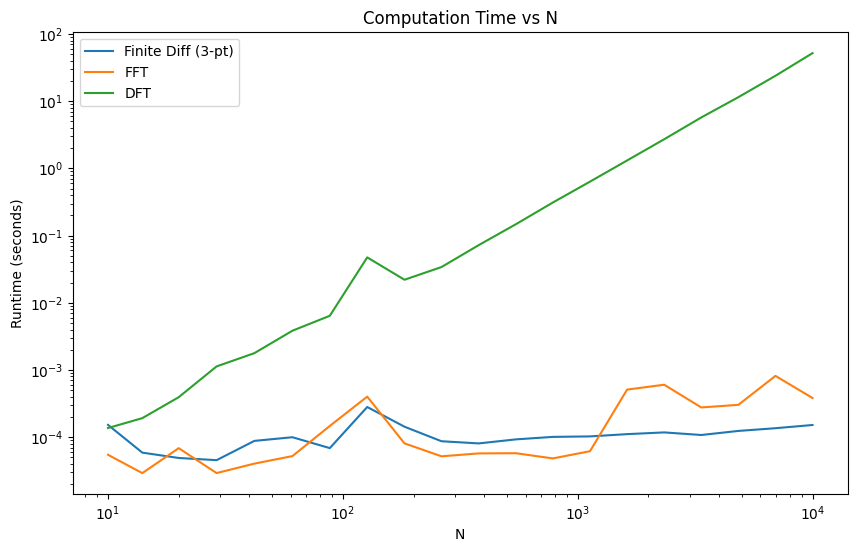

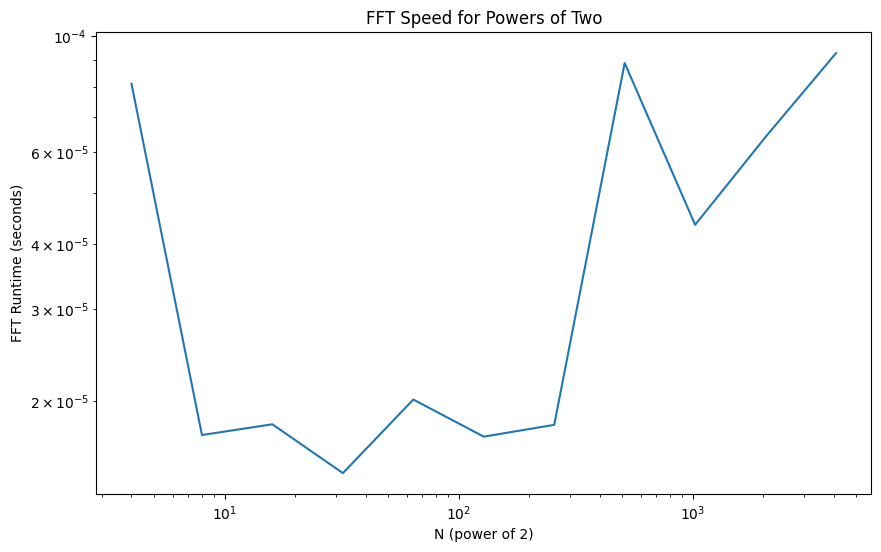

In [11]:
def measure_runtime(method_func, N, derivative_order, stencil=None):
    L_local = 2.0
    x_grid = np.linspace(-L_local, L_local, N, endpoint=False)
    dx_local = x_grid[1] - x_grid[0]
    f_ex, df_ex, ddf_ex = exact_derivatives(x_grid)
    
    start_t = time.perf_counter()
    
    if method_func == finite_diff_derivative:
        method_func(f_ex, dx_local, derivative_order, stencil)
    else:
        method_func(f_ex, dx_local, derivative_order)
    
    end_t = time.perf_counter()
    return end_t - start_t

time_fd = []
time_fft = []
time_dft = []

N_range_time = np.logspace(1, 4, 20, dtype=int)
for Nn in N_range_time:
    fd_t = measure_runtime(finite_diff_derivative, Nn, 2, stencil_3pt)
    time_fd.append(fd_t)
    
    fft_t = measure_runtime(fft_based_derivative, Nn, 2)
    time_fft.append(fft_t)
    
    dft_t = measure_runtime(dft_matrix_derivative, Nn, 2)
    time_dft.append(dft_t)

plt.figure(figsize=(10, 6))
plt.loglog(N_range_time, time_fd, label='Finite Diff (3-pt)')
plt.loglog(N_range_time, time_fft, label='FFT')
plt.loglog(N_range_time, time_dft, label='DFT')
plt.xlabel('N')
plt.ylabel('Runtime (seconds)')
plt.title('Computation Time vs N')
plt.legend()
plt.show()

powers_of_two = [2**k for k in range(2, 13)]
fft_times_pow2 = []
for val in powers_of_two:
    tpow = measure_runtime(fft_based_derivative, val, 2)
    fft_times_pow2.append(tpow)

plt.figure(figsize=(10, 6))
plt.loglog(powers_of_two, fft_times_pow2)
plt.xlabel('N (power of 2)')
plt.ylabel('FFT Runtime (seconds)')
plt.title('FFT Speed for Powers of Two')
plt.show()
